In [1]:
from hamilton_ice.pipeline import get_func_args, object_io_nodes, build_pipeline
from hamilton_ice.io.artifact import artifact
from hamilton_ice.io.pandas import pandas_csv_source, pandas_msgpack
from hamilton_ice.io.dummy import dummy
from hamilton_ice.util.graphviz import dag_plot
import pandas as pd
import numpy as np
import random
import torch
from dataclasses import dataclass
from hamilton_ice.util.graphviz import dag_plot

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Questions
* Use overrides instead of partial results
* Feature engineering is shared through module
* How to seperate code into docker containers for pyspark and pytorch
    * @config.when
    * module separation
    * all in one
* Rerun the dag for each epoch

# Misc DataClass Code
These are used to describe shapes for more complex composite datastructures that contain config, combinations of training/validation data, or loss metrics.

In [2]:
# We maintain a small holdout set of data for validation purposes.
# I was pretty sloppy with this, it's not randomized properly, and it's 
# small and very noisy. I had a much better version of this that I can recreate later.
validation = None

# This is a singular config object that's 
# used for any free parameter we wish to control 
# within the training/serving pipeline.  In prod it could be sealed.
@dataclass
class Config:
    observed_size = 0
    reservoir_size = 50
    random_seed = 42
    output_field = "Survived"

# Since everything is streaming in this approach, we can generate both training and validation
# minibatches on the fly.  This dataclass clearly specifies them both as they are chunked
# out of the data.
@dataclass
class TrainingValidationMinibatch:
    train : pd.DataFrame
    validation : pd.DataFrame
        
# Ditto for metrics on the minibatch metrics
@dataclass
class AnnotatedLoss:
    loss : float
    validation_loss : float


In [3]:
# Simple Titanic
# This is a simple class interface that generates raw minibatches from a source.
# The source function just needs to return a url/file location to pull chunked CSV records from.
class Titanic:
    @artifact
    def params():
        return {}
    
    @artifact
    def config():
        return Config()
    
    @pandas_csv_source
    def minibatch(config):
        return "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"    

# We can build the pipeline so that we can use the generators
build_pipeline(Titanic)        

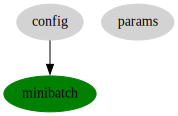

In [4]:
# Not much to see here on the DAG plot.  We pass config into minibatch. 
# There's an extra params node that's not used but required by the code.
# I was too lazy to remove it here, just ignore it.
dag_plot(Titanic)

In [5]:
# Let's look at a sample of the raw data from the generator, it's a pandas dataframe.
next(Titanic.minibatch.generator())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
# We can continue to build on the Titanic DAG.
# This time by adding functions useful for normalization.
class TitanicNormalized(Titanic):       
    @dummy
    def normalized_data(minibatch, config):
        dat = minibatch
        normalized = pd.DataFrame({
            "Survived" : dat["Survived"].astype(float),
            "NormPclass" : dat["Pclass"]/3,
            "MaleSex" : (dat["Sex"] == "male").astype(float),
            "FemaleSex" : (dat["Sex"] == "female").astype(float),
            "NormAge" : dat["Age"] / 100,
            "NormSibSp" :dat["SibSp"] /10,
            "NormParch" : dat["Parch"]/10,
            "NormFare" : dat["Fare"]/1000,
            "Embarked_C" : (dat["Embarked"] == "C").astype(float),
            "Embarked_S" : (dat["Embarked"] == "S").astype(float),
            "Embarked_Q" : (dat["Embarked"] == "Q").astype(float),
        })
        mean_value = normalized["NormAge"].mean(skipna=True)
        normalized["NormAge"].fillna(mean_value, inplace=True)
        yield normalized
    
    @dummy
    def annotated_data(normalized_data, config):
#         np.random.seed(config.random_seed)
        msk = np.random.rand(len(normalized_data)) < 0.8
        normalized_data["train"] = msk
        normalized_data["eval"] = ~msk
        yield normalized_data

build_pipeline(TitanicNormalized)  

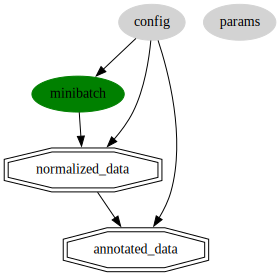

In [7]:
dag_plot(TitanicNormalized)

In [12]:
# Here's the normalized step. All the values are between 0 and 1 here.  
# (We can do better norms I know)
gen = TitanicNormalized.normalized_data.generator() 

In [27]:
for i in range(10):
    print(next(gen).tail(1))

StopIteration: 

In [22]:
gen

<generator object build_generator.<locals>.generator at 0x168b5eac0>

In [16]:
# Here we are adding "train" and "eval" flags for each record in the chunked iterator.
# Note that we lock the random seed to ensure these are the same each run.
next(TitanicNormalized.annotated_data.generator()).head().iloc[:,-5:]

,Embarked_C,Embarked_S,Embarked_Q,train,eval
0,0.0,1.0,0.0,True,False
1,1.0,0.0,0.0,True,False
2,0.0,1.0,0.0,False,True
3,0.0,1.0,0.0,True,False
4,0.0,1.0,0.0,False,True


In [17]:
validation

In [18]:
# This DAG adds in annotated training phase that generates training and validation minibatches
class TitanicAnnotated(TitanicNormalized):        
    @dummy    
    def evaluate(annotated_data):  
        yield annotated_data[annotated_data["eval"]]
    
    
    @dummy                                 
    def annotated_train(annotated_data, config):
        train = annotated_data[annotated_data["train"]].drop(["train", "eval"], axis = 1).copy()
        
        global validation
        
        k = random.randint(0, config.reservoir_size)
        if validation is None:
            validation = train.copy()
        else:
            # swap an element with reservoir
            val_idx = random.choice(validation.index)
            train_idx = random.choice(train.index)
            print("swap", val_idx, train_idx)
            validation.loc[val_idx] = train.loc[train_idx]
            print(validation['Survived'].sum())

        yield TrainingValidationMinibatch(train=train, validation=validation)
        
build_pipeline(TitanicAnnotated)

In [ ]:
dag_plot(TitanicAnnotated)

In [ ]:
# Here we are peeking into the train/validation minibatches. 
# Initially the validation minibatch will look identical, but later on it will contain samples
# across the epoch.

tv = next(TitanicAnnotated.annotated_train.generator())
print("TRAIN:\n")
print(tv.train.head())
print("\nVALIDATE:\n")
print(tv.validation.head())

In [ ]:
i = 1

In [30]:
# This DAG will contain the config for the model, and use the upstream annotated 
# minibatches for trainining the model.

class TitanicTrain(TitanicAnnotated):
    @artifact
    def optimizer(model):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
        return optimizer
    
    @artifact
    def criterion(config):
        return torch.nn.BCELoss() 
    
    @dummy
    def train(annotated_train, model, optimizer, criterion):
        optimizer.zero_grad()
        train = annotated_train.train.drop(["Survived"], axis=1).to_numpy()
        train_features = torch.tensor(train)
        train_outputs = model(train_features.float())
        train_labels = torch.tensor(annotated_train.train["Survived"].to_numpy())

        validation = annotated_train.validation.drop(["Survived"], axis=1).to_numpy()
        validation_features = torch.tensor(validation)
        validation_outputs = model(validation_features.float())
        validation_labels = torch.tensor(annotated_train.validation["Survived"].to_numpy())
        loss = criterion(
            train_outputs.flatten().float(), 
            train_labels.flatten().float()
            )

        validation_loss = criterion(
            validation_outputs.flatten().float(), 
            validation_labels.flatten().float()
            )

        loss.backward() 
        optimizer.step()
        global i
        i += 1
        print('training', i)
      
        yield AnnotatedLoss(loss = loss.item(), validation_loss = validation_loss.item())
    
    @artifact
    def model (config, annotated_train):
        n_features = annotated_train.train.drop(["Survived"], axis=1).shape[1]
        model = torch.nn.Sequential(torch.nn.Linear(n_features, 50),
                            torch.nn.ReLU(),
                            torch.nn.Linear(50, 1),
                            torch.nn.Sigmoid())
        return model
        
build_pipeline(TitanicTrain)

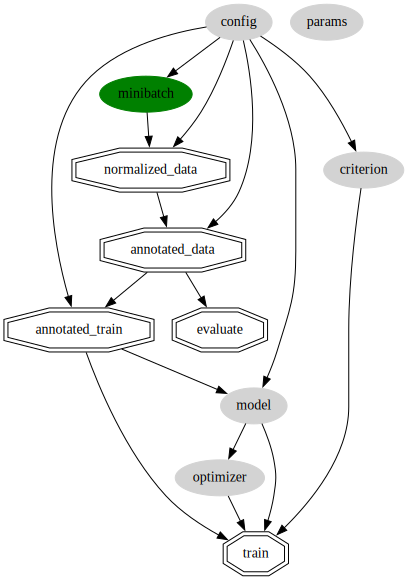

In [29]:
dag_plot(TitanicTrain)

In [31]:
# Here's a dead simple training loop.  
# This easily be abstracted away with an additional feature/service, but it's
# easy enough to follow along here.
epochs = []
for epoch in range(0,200):
    if epoch % 100 == 0:
        print(f"epoch: {epoch}")
    epoch = []
    for aloss in TitanicTrain.train.generator():
        epoch.append(aloss.__dict__)
    epoch = pd.DataFrame.from_records(epoch)
    epochs.append(epoch.mean())

epoch: 0
swap 0 3
13.0
training 1
swap 0 34
12.0
training 2
swap 20 89
12.0
training 3
swap 14 111
12.0
training 4
swap 2 146
12.0
training 5
swap 20 180
12.0
training 6
swap 5 213
12.0
training 7
swap 3 229
11.0
training 8
swap 14 259
12.0
training 9
swap 28 307
12.0
training 10
swap 7 336
12.0
training 11
swap 5 364
12.0
training 12
swap 11 390
12.0
training 13
swap 11 430
12.0
training 14
swap 21 458
12.0
training 15
swap 30 487
12.0
training 16
swap 7 516
13.0
training 17
swap 17 545
12.0
training 18
swap 7 580
12.0
training 19
swap 23 619
11.0
training 20
swap 1 654
10.0
training 21
swap 11 687
9.0
training 22
swap 16 733
9.0
training 23
swap 3 740
10.0
training 24
swap 28 773
9.0
training 25
swap 7 830
9.0
training 26
swap 29 838
10.0
training 27
swap 7 883
9.0
training 28
swap 28 25
10.0
training 29
swap 17 46
10.0
training 30
swap 29 69
9.0
training 31
swap 18 122
9.0
training 32
swap 25 155
8.0
training 33
swap 7 164
8.0
training 34
swap 13 200
8.0
training 35
swap 20 225
8.0


training 299
swap 21 615
8.0
training 300
swap 5 654
7.0
training 301
swap 5 699
7.0
training 302
swap 8 705
7.0
training 303
swap 8 748
7.0
training 304
swap 25 771
6.0
training 305
swap 16 831
7.0
training 306
swap 28 861
7.0
training 307
swap 20 864
7.0
training 308
swap 3 8
8.0
training 309
swap 27 52
8.0
training 310
swap 17 82
8.0
training 311
swap 22 98
9.0
training 312
swap 3 128
9.0
training 313
swap 14 187
10.0
training 314
swap 5 219
10.0
training 315
swap 21 228
9.0
training 316
swap 29 267
10.0
training 317
swap 14 298
10.0
training 318
swap 11 327
11.0
training 319
swap 7 358
12.0
training 320
swap 3 384
11.0
training 321
swap 25 430
12.0
training 322
swap 1 466
12.0
training 323
swap 0 493
12.0
training 324
swap 13 536
12.0
training 325
swap 5 565
12.0
training 326
swap 30 594
11.0
training 327
swap 29 610
10.0
training 328
swap 21 658
10.0
training 329
swap 11 695
9.0
training 330
swap 2 708
9.0
training 331
swap 2 742
9.0
training 332
swap 17 768
8.0
training 333
swap 

training 601
swap 25 416
7.0
training 602
swap 7 475
7.0
training 603
swap 29 484
8.0
training 604
swap 18 530
9.0
training 605
swap 11 566
9.0
training 606
swap 7 589
9.0
training 607
swap 13 622
9.0
training 608
swap 3 641
10.0
training 609
swap 28 700
11.0
training 610
swap 22 717
11.0
training 611
swap 23 760
10.0
training 612
swap 9 798
10.0
training 613
swap 17 807
10.0
training 614
swap 21 847
10.0
training 615
swap 22 890
9.0
training 616
swap 18 19
9.0
training 617
swap 27 38
9.0
training 618
swap 2 80
9.0
training 619
swap 29 126
8.0
training 620
swap 8 159
8.0
training 621
swap 29 160
8.0
training 622
swap 8 203
8.0
training 623
swap 7 255
9.0
training 624
swap 28 272
9.0
training 625
swap 9 293
9.0
training 626
swap 3 348
9.0
training 627
swap 1 378
9.0
training 628
swap 16 402
9.0
training 629
swap 30 428
8.0
training 630
swap 7 462
7.0
training 631
swap 5 494
7.0
training 632
swap 21 531
7.0
training 633
swap 3 555
6.0
training 634
swap 27 603
6.0
training 635
swap 7 609


training 888
swap 22 640
9.0
training 889
swap 7 673
10.0
training 890
swap 11 725
9.0
training 891
swap 23 760
8.0
training 892
swap 30 793
8.0
training 893
swap 9 820
9.0
training 894
swap 17 851
9.0
training 895
swap 2 874
10.0
training 896
swap 8 21
11.0
training 897
swap 9 42
10.0
training 898
swap 8 92
9.0
training 899
swap 20 126
9.0
training 900
swap 28 146
9.0
training 901
swap 14 162
9.0
training 902
swap 22 214
9.0
training 903
swap 13 247
9.0
training 904
swap 7 283
9.0
training 905
swap 7 293
8.0
training 906
swap 7 322
9.0
training 907
swap 2 359
9.0
training 908
swap 16 412
10.0
training 909
swap 13 446
10.0
training 910
swap 29 462
10.0
training 911
swap 20 489
11.0
training 912
swap 30 543
12.0
training 913
swap 17 551
12.0
training 914
swap 16 588
11.0
training 915
swap 27 639
11.0
training 916
swap 1 662
10.0
training 917
swap 29 687
10.0
training 918
swap 1 720
11.0
training 919
swap 1 767
10.0
training 920
swap 27 789
10.0
training 921
swap 2 823
10.0
training 922


training 1187
swap 0 356
9.0
training 1188
swap 8 406
8.0
training 1189
swap 29 420
8.0
training 1190
swap 16 468
8.0
training 1191
swap 16 496
9.0
training 1192
swap 0 524
8.0
training 1193
swap 1 574
8.0
training 1194
swap 0 581
9.0
training 1195
swap 28 630
10.0
training 1196
swap 14 641
10.0
training 1197
swap 29 674
10.0
training 1198
swap 1 711
10.0
training 1199
swap 29 755
11.0
training 1200
swap 2 791
10.0
training 1201
swap 27 829
11.0
training 1202
swap 11 850
11.0
training 1203
swap 25 865
12.0
training 1204
swap 18 5
12.0
training 1205
swap 13 56
12.0
training 1206
swap 11 84
13.0
training 1207
swap 21 125
14.0
training 1208
swap 20 131
14.0
training 1209
swap 16 189
13.0
training 1210
swap 17 222
13.0
training 1211
swap 28 251
12.0
training 1212
swap 2 282
12.0
training 1213
swap 16 315
13.0
training 1214
swap 27 334
13.0
training 1215
swap 1 381
14.0
training 1216
swap 13 389
14.0
training 1217
swap 27 433
13.0
training 1218
swap 8 456
13.0
training 1219
swap 20 481
13.0

swap 13 752
6.0
training 1480
swap 25 774
7.0
training 1481
swap 18 825
7.0
training 1482
swap 30 838
8.0
training 1483
swap 17 887
9.0
training 1484
swap 13 29
9.0
training 1485
swap 21 47
10.0
training 1486
swap 5 64
9.0
training 1487
swap 20 115
8.0
training 1488
swap 18 159
8.0
training 1489
swap 25 164
7.0
training 1490
swap 8 193
8.0
training 1491
swap 30 252
7.0
training 1492
swap 2 256
8.0
training 1493
swap 2 296
7.0
training 1494
swap 20 336
7.0
training 1495
swap 23 353
7.0
training 1496
swap 11 399
8.0
training 1497
swap 9 418
7.0
training 1498
swap 21 478
6.0
training 1499
swap 7 490
5.0
training 1500
swap 9 517
5.0
training 1501
swap 16 566
5.0
training 1502
swap 30 589
5.0
training 1503
swap 30 618
6.0
training 1504
swap 9 649
7.0
training 1505
swap 29 699
7.0
training 1506
swap 29 711
7.0
training 1507
swap 17 745
6.0
training 1508
swap 7 769
6.0
training 1509
swap 1 814
5.0
training 1510
swap 11 839
5.0
training 1511
swap 2 879
6.0
training 1512
swap 27 13
6.0
training

swap 27 27
9.0
training 1793
swap 28 51
8.0
training 1794
swap 14 85
9.0
training 1795
swap 23 117
8.0
training 1796
swap 18 147
8.0
training 1797
swap 25 185
8.0
training 1798
swap 8 195
8.0
training 1799
swap 7 241
9.0
training 1800
swap 1 275
10.0
training 1801
swap 22 300
11.0
training 1802
swap 3 347
12.0
training 1803
swap 21 363
11.0
training 1804
swap 1 403
10.0
training 1805
swap 29 441
10.0
training 1806
swap 27 461
10.0
training 1807
swap 2 496
10.0
training 1808
swap 21 514
10.0
training 1809
swap 28 561
10.0
training 1810
swap 25 581
11.0
training 1811
swap 14 630
11.0
training 1812
swap 2 663
10.0
training 1813
swap 20 672
9.0
training 1814
swap 29 735
9.0
training 1815
swap 3 741
8.0
training 1816
swap 22 769
7.0
training 1817
swap 14 807
6.0
training 1818
swap 25 857
6.0
training 1819
swap 22 870
6.0
training 1820
swap 16 15
6.0
training 1821
swap 27 55
7.0
training 1822
swap 21 77
7.0
training 1823
swap 9 118
7.0
training 1824
swap 30 147
7.0
training 1825
swap 30 178


training 2093
swap 23 688
8.0
training 2094
swap 25 721
8.0
training 2095
swap 0 747
8.0
training 2096
swap 16 794
8.0
training 2097
swap 1 814
8.0
training 2098
swap 21 837
8.0
training 2099
swap 25 873
8.0
training 2100
swap 22 7
8.0
training 2101
swap 27 60
8.0
training 2102
swap 13 78
9.0
training 2103
swap 1 112
9.0
training 2104
swap 17 159
8.0
training 2105
swap 3 185
8.0
training 2106
swap 21 201
8.0
training 2107
swap 25 231
8.0
training 2108
swap 30 272
9.0
training 2109
swap 7 292
9.0
training 2110
swap 1 333
9.0
training 2111
swap 0 355
8.0
training 2112
swap 11 390
9.0
training 2113
swap 14 429
9.0
training 2114
swap 22 475
9.0
training 2115
swap 11 497
8.0
training 2116
swap 22 520
9.0
training 2117
swap 11 546
10.0
training 2118
swap 23 595
10.0
training 2119
swap 3 623
10.0
training 2120
swap 13 659
9.0
training 2121
swap 3 699
9.0
training 2122
swap 9 733
8.0
training 2123
swap 7 746
8.0
training 2124
swap 28 792
8.0
training 2125
swap 23 813
8.0
training 2126
swap 14 

training 2370
swap 1 597
8.0
training 2371
swap 13 614
8.0
training 2372
swap 20 665
7.0
training 2373
swap 14 687
6.0
training 2374
swap 9 722
5.0
training 2375
swap 16 737
6.0
training 2376
swap 23 783
5.0
training 2377
swap 0 812
5.0
training 2378
swap 28 848
5.0
training 2379
swap 28 877
5.0
training 2380
swap 22 28
6.0
training 2381
swap 30 63
6.0
training 2382
swap 21 88
7.0
training 2383
swap 29 101
7.0
training 2384
swap 27 143
7.0
training 2385
swap 18 183
7.0
training 2386
swap 29 198
8.0
training 2387
swap 11 234
7.0
training 2388
swap 25 266
7.0
training 2389
swap 17 302
7.0
training 2390
swap 14 344
7.0
training 2391
swap 14 362
7.0
training 2392
swap 2 407
8.0
training 2393
swap 21 419
7.0
training 2394
swap 0 478
7.0
training 2395
swap 17 501
7.0
training 2396
swap 21 514
7.0
training 2397
swap 20 547
8.0
training 2398
swap 13 578
8.0
training 2399
swap 0 612
9.0
training 2400
swap 16 642
8.0
training 2401
swap 18 678
7.0
training 2402
swap 9 710
8.0
training 2403
swap 2

training 2671
swap 11 352
11.0
training 2672
swap 8 406
10.0
training 2673
swap 5 440
10.0
training 2674
swap 20 457
11.0
training 2675
swap 1 501
11.0
training 2676
swap 21 524
10.0
training 2677
swap 23 555
10.0
training 2678
swap 17 595
10.0
training 2679
swap 9 617
10.0
training 2680
swap 23 647
11.0
training 2681
swap 21 701
12.0
training 2682
swap 16 716
12.0
training 2683
swap 25 740
12.0
training 2684
swap 8 787
12.0
training 2685
swap 17 825
12.0
training 2686
swap 25 851
11.0
training 2687
swap 14 865
12.0
training 2688
swap 0 18
11.0
training 2689
swap 14 42
10.0
training 2690
swap 28 67
10.0
training 2691
swap 14 110
10.0
training 2692
swap 29 145
9.0
training 2693
swap 22 188
9.0
training 2694
swap 23 219
8.0
training 2695
swap 16 237
8.0
training 2696
swap 20 286
8.0
training 2697
swap 22 301
9.0
training 2698
swap 21 330
9.0
training 2699
swap 25 373
9.0
training 2700
swap 3 403
8.0
training 2701
swap 9 424
8.0
training 2702
swap 30 472
8.0
training 2703
swap 14 485
8.0


training 2980
swap 22 398
5.0
training 2981
swap 16 419
5.0
training 2982
swap 16 473
6.0
training 2983
swap 20 489
7.0
training 2984
swap 30 516
8.0
training 2985
swap 22 552
8.0
training 2986
swap 5 591
8.0
training 2987
swap 22 635
9.0
training 2988
swap 13 661
9.0
training 2989
swap 17 695
9.0
training 2990
swap 20 708
9.0
training 2991
swap 14 752
9.0
training 2992
swap 20 776
8.0
training 2993
swap 28 812
8.0
training 2994
swap 27 843
8.0
training 2995
swap 23 864
7.0
training 2996
swap 7 27
7.0
training 2997
swap 29 55
8.0
training 2998
swap 21 95
8.0
training 2999
swap 5 100
7.0
training 3000
swap 0 144
7.0
training 3001
swap 22 176
6.0
training 3002
swap 22 211
7.0
training 3003
swap 21 225
7.0
training 3004
swap 17 266
7.0
training 3005
swap 22 300
7.0
training 3006
swap 28 334
8.0
training 3007
swap 29 361
7.0
training 3008
swap 2 402
6.0
training 3009
swap 3 424
5.0
training 3010
swap 5 452
5.0
training 3011
swap 16 481
4.0
training 3012
swap 29 532
4.0
training 3013
swap 1

training 3294
swap 7 580
10.0
training 3295
swap 8 614
10.0
training 3296
swap 16 670
10.0
training 3297
swap 5 690
11.0
training 3298
swap 20 735
10.0
training 3299
swap 14 750
10.0
training 3300
swap 22 788
10.0
training 3301
swap 18 814
9.0
training 3302
swap 13 849
9.0
training 3303
swap 23 878
9.0
training 3304
swap 1 18
8.0
training 3305
swap 22 48
7.0
training 3306
swap 13 90
6.0
training 3307
swap 1 104
6.0
training 3308
swap 20 133
7.0
training 3309
swap 30 185
6.0
training 3310
swap 5 209
6.0
training 3311
swap 18 234
6.0
training 3312
swap 28 286
7.0
training 3313
swap 25 306
8.0
training 3314
swap 13 325
9.0
training 3315
swap 1 361
9.0
training 3316
swap 29 398
9.0
training 3317
swap 5 442
8.0
training 3318
swap 18 478
8.0
training 3319
swap 16 507
8.0
training 3320
swap 7 512
8.0
training 3321
swap 28 548
7.0
training 3322
swap 2 584
7.0
training 3323
swap 8 624
7.0
training 3324
swap 29 647
8.0
training 3325
swap 9 672
8.0
training 3326
swap 16 729
7.0
training 3327
swap

training 3583
swap 22 867
7.0
training 3584
swap 3 22
8.0
training 3585
swap 0 46
8.0
training 3586
swap 8 71
8.0
training 3587
swap 28 104
7.0
training 3588
swap 3 148
6.0
training 3589
swap 9 168
5.0
training 3590
swap 23 223
5.0
training 3591
swap 23 227
5.0
training 3592
swap 2 282
4.0
training 3593
swap 14 319
5.0
training 3594
swap 17 346
5.0
training 3595
swap 2 371
5.0
training 3596
swap 21 414
6.0
training 3597
swap 16 418
6.0
training 3598
swap 23 466
6.0
training 3599
swap 9 488
6.0
training 3600
swap 11 528
5.0
training 3601
swap 20 548
5.0
training 3602
swap 25 605
5.0
training 3603
swap 22 636
5.0
training 3604
swap 22 669
6.0
training 3605
swap 5 680
6.0
training 3606
swap 29 708
7.0
training 3607
swap 21 756
6.0
training 3608
swap 21 798
6.0
training 3609
swap 5 823
7.0
training 3610
swap 17 832
6.0
training 3611
swap 23 868
6.0
training 3612
swap 13 3
6.0
training 3613
swap 20 60
6.0
training 3614
swap 17 78
7.0
training 3615
swap 21 98
8.0
training 3616
swap 7 133
9.0

training 3886
swap 16 708
10.0
training 3887
swap 5 758
10.0
training 3888
swap 8 770
10.0
training 3889
swap 7 814
9.0
training 3890
swap 27 853
9.0
training 3891
swap 20 889
9.0
training 3892
swap 16 11
9.0
training 3893
swap 20 52
9.0
training 3894
swap 8 87
9.0
training 3895
swap 16 104
8.0
training 3896
swap 2 134
8.0
training 3897
swap 29 168
8.0
training 3898
swap 20 210
7.0
training 3899
swap 14 247
8.0
training 3900
swap 18 269
9.0
training 3901
swap 8 309
10.0
training 3902
swap 0 336
9.0
training 3903
swap 29 377
9.0
training 3904
swap 30 393
9.0
training 3905
swap 5 427
10.0
training 3906
swap 14 460
10.0
training 3907
swap 20 510
11.0
training 3908
swap 18 537
11.0
training 3909
swap 2 547
12.0
training 3910
swap 21 601
11.0
training 3911
swap 16 608
12.0
training 3912
swap 9 642
12.0
training 3913
swap 5 682
11.0
training 3914
swap 3 725
10.0
training 3915
swap 5 763
11.0
training 3916
swap 5 798
10.0
training 3917
swap 20 823
10.0
training 3918
swap 9 862
11.0
training 3

swap 27 31
14.0
training 4201
swap 17 46
13.0
training 4202
swap 13 94
13.0
training 4203
swap 11 99
12.0
training 4204
swap 5 134
12.0
training 4205
swap 1 166
12.0
training 4206
swap 20 192
13.0
training 4207
swap 30 236
12.0
training 4208
swap 22 274
13.0
training 4209
swap 5 318
14.0
training 4210
swap 27 323
14.0
training 4211
swap 28 383
15.0
training 4212
swap 18 392
15.0
training 4213
swap 0 428
14.0
training 4214
swap 17 449
15.0
training 4215
swap 9 484
16.0
training 4216
swap 7 527
15.0
training 4217
swap 30 553
16.0
training 4218
swap 14 596
16.0
training 4219
swap 5 610
15.0
training 4220
swap 2 656
15.0
training 4221
swap 5 687
15.0
training 4222
swap 1 708
15.0
training 4223
swap 27 741
14.0
training 4224
swap 17 786
14.0
training 4225
swap 7 804
15.0
training 4226
swap 22 854
14.0
training 4227
swap 18 867
14.0
training 4228
swap 13 2
15.0
training 4229
swap 22 48
15.0
training 4230
swap 18 78
16.0
training 4231
swap 0 105
16.0
training 4232
swap 2 137
16.0
training 423

training 4473
swap 1 699
11.0
training 4474
swap 11 725
10.0
training 4475
swap 17 746
9.0
training 4476
swap 27 769
9.0
training 4477
swap 9 829
10.0
training 4478
swap 14 842
10.0
training 4479
swap 3 871
11.0
training 4480
swap 18 8
12.0
training 4481
swap 17 63
12.0
training 4482
swap 21 87
12.0
training 4483
swap 23 122
11.0
training 4484
swap 29 144
10.0
training 4485
swap 11 162
10.0
training 4486
swap 18 197
9.0
training 4487
swap 3 230
9.0
training 4488
swap 20 259
9.0
training 4489
swap 21 298
10.0
training 4490
swap 2 331
10.0
training 4491
swap 20 356
10.0
training 4492
swap 8 415
10.0
training 4493
swap 14 440
10.0
training 4494
swap 30 455
11.0
training 4495
swap 28 509
11.0
training 4496
swap 20 535
11.0
training 4497
swap 25 559
11.0
training 4498
swap 14 588
10.0
training 4499
swap 25 623
9.0
training 4500
swap 29 653
10.0
training 4501
swap 18 697
11.0
training 4502
swap 3 731
10.0
training 4503
swap 29 753
9.0
training 4504
swap 1 793
9.0
training 4505
swap 0 810
8.0

swap 14 21
12.0
training 4789
swap 0 39
12.0
training 4790
swap 27 76
12.0
training 4791
swap 16 98
12.0
training 4792
swap 30 144
12.0
training 4793
swap 8 182
12.0
training 4794
swap 7 194
12.0
training 4795
swap 8 235
12.0
training 4796
swap 17 278
12.0
training 4797
swap 7 293
11.0
training 4798
swap 25 322
11.0
training 4799
swap 8 361
11.0
training 4800
swap 14 387
11.0
training 4801
swap 27 434
11.0
training 4802
swap 9 475
11.0
training 4803
swap 18 489
11.0
training 4804
swap 17 522
11.0
training 4805
swap 22 558
11.0
training 4806
swap 27 605
11.0
training 4807
swap 11 619
10.0
training 4808
swap 8 662
10.0
training 4809
swap 0 700
10.0
training 4810
swap 30 711
10.0
training 4811
swap 27 759
11.0
training 4812
swap 25 772
10.0
training 4813
swap 16 810
9.0
training 4814
swap 20 834
9.0
training 4815
swap 9 864
9.0
training 4816
swap 29 30
9.0
training 4817
swap 7 55
10.0
training 4818
swap 18 64
9.0
training 4819
swap 20 101
9.0
training 4820
swap 11 135
9.0
training 4821
sw

training 5067
swap 11 882
7.0
training 5068
swap 11 13
7.0
training 5069
swap 20 52
7.0
training 5070
swap 0 88
8.0
training 5071
swap 14 101
8.0
training 5072
swap 0 156
8.0
training 5073
swap 14 185
8.0
training 5074
swap 7 217
8.0
training 5075
swap 28 239
8.0
training 5076
swap 30 264
8.0
training 5077
swap 18 301
9.0
training 5078
swap 1 324
9.0
training 5079
swap 22 370
10.0
training 5080
swap 18 385
9.0
training 5081
swap 25 447
10.0
training 5082
swap 0 462
9.0
training 5083
swap 21 502
8.0
training 5084
swap 1 516
9.0
training 5085
swap 8 561
8.0
training 5086
swap 18 584
8.0
training 5087
swap 14 608
9.0
training 5088
swap 21 655
9.0
training 5089
swap 0 697
10.0
training 5090
swap 27 734
10.0
training 5091
swap 8 744
11.0
training 5092
swap 14 791
10.0
training 5093
swap 7 802
11.0
training 5094
swap 27 841
11.0
training 5095
swap 11 877
11.0
training 5096
swap 25 4
10.0
training 5097
swap 30 50
10.0
training 5098
swap 27 69
10.0
training 5099
swap 21 108
10.0
training 5100


training 5338
swap 9 605
9.0
training 5339
swap 17 632
10.0
training 5340
swap 9 641
11.0
training 5341
swap 1 690
12.0
training 5342
swap 20 735
12.0
training 5343
swap 22 753
12.0
training 5344
swap 30 780
13.0
training 5345
swap 7 812
13.0
training 5346
swap 14 836
13.0
training 5347
swap 1 873
12.0
training 5348
swap 22 10
13.0
training 5349
swap 5 39
14.0
training 5350
swap 8 92
13.0
training 5351
swap 28 109
14.0
training 5352
swap 17 142
14.0
training 5353
swap 0 171
13.0
training 5354
swap 8 214
13.0
training 5355
swap 2 251
12.0
training 5356
swap 9 259
12.0
training 5357
swap 17 289
12.0
training 5358
swap 30 351
11.0
training 5359
swap 30 363
11.0
training 5360
swap 9 401
10.0
training 5361
swap 29 419
9.0
training 5362
swap 13 457
9.0
training 5363
swap 11 491
8.0
training 5364
swap 14 542
8.0
training 5365
swap 27 574
8.0
training 5366
swap 3 598
7.0
training 5367
swap 16 636
7.0
training 5368
swap 9 641
8.0
training 5369
swap 29 676
8.0
training 5370
swap 5 732
7.0
traini

In [ ]:
# Let's take a look at our loss (which should be smooth), against our noisy/small validation set.
pd.concat(epochs, axis=1).transpose().plot()

In [ ]:
# We can access the trained model by calling its artifact method. 
model = TitanicTrain.model.artifact()
model